Attemping to infer the parameters as spatial-temporal functions from low-fidelity PDE solution (KDE).

The PDE is assumed to have form:
$$
    u_t + \frac{\partial}{\partial x}\bigg[\mathcal{V}(t,x)u\bigg] = \frac{\partial}{\partial x}\bigg[\mathcal{D}(t,x)u_x\bigg]
$$ where $\mathcal{V}, \mathcal{D}$ are parameterized as separate NNs.

(06/15/2023) Method does not work well at capturing time intervals where the PDE solution changes rapidly. The method may capture the steady state solution well.

In [1]:
from PINN.PhysicsInformedROPDF import *
# Testing
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import numpy as np
import scipy

import time
import pylab as pl
from IPython import display
from IPython.display import clear_output

In [ ]:
# modify dataset
full_data_path = "../data/LinearOscillator/OU_Noise_energy.mat"
data = scipy.io.loadmat(full_data_path)
# subsample factor
space_factor = 5
time_factor = 5
new_pmc = (data["v_density"].T)[0:-1:time_factor, 0:-1:space_factor]
new_xgrid = data["xi"][:, 0:-1:space_factor]
new_tgrid = data["tspan"][:, 0:-1:time_factor]
# save new data
new_data_path = "../data/LinearOscillator/OU_Noise_energy_subsample{}.mat".format(int(space_factor*time_factor))
scipy.io.savemat(
    new_data_path, {"pmc": new_pmc, "xgrid": new_xgrid, "tgrid": new_tgrid}
)

In [ ]:
# test saved data
new_data_path = "../data/LinearOscillator/OU_Noise_energy_subsample25.mat"
data = scipy.io.loadmat(new_data_path)
print(data["pmc"].shape, data["xgrid"].shape, data["tgrid"].shape)

Experiments below

In [2]:
# set random seeds
np.random.seed(10)
torch.manual_seed(10);

data_path = "../data/LinearOscillator/OU_Noise_energy_subsample25.mat"
data = scipy.io.loadmat(data_path)

Visualize solution over time.

In [3]:
visualize = False
if visualize:
    for i in range(pinn.nt):
        plt.figure(1);
        plt.plot(pinn.raw_data["pmc"][i, :], color="red")
        plt.ylim([0, 0.04])
        display.clear_output(wait=True)
        display.display(pl.gcf())
        plt.clf()
        time.sleep(0.01)

Visualize advection velocity over time by mean-tracking.

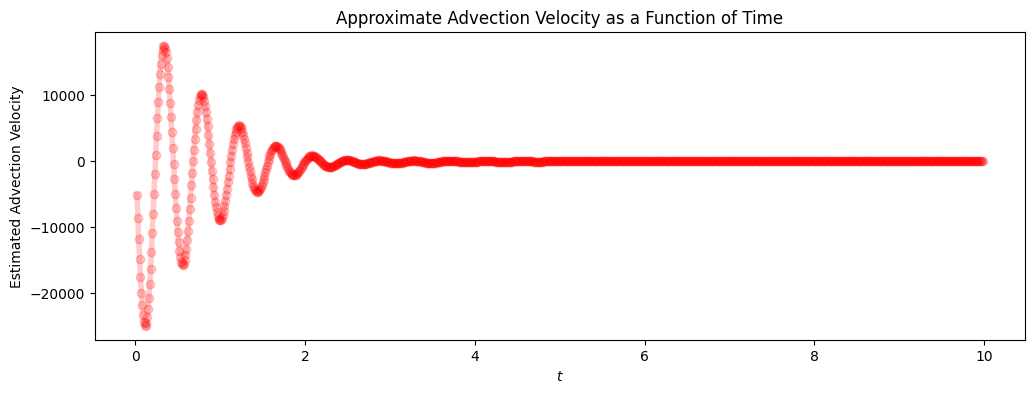

In [4]:
p_sol = data["pmc"]
xgrid = data["xgrid"].flatten()
dx = xgrid[1]-xgrid[0]
nx = len(xgrid)
tgrid = data["tgrid"].flatten()
dt = tgrid[1]-tgrid[0]
nt = len(tgrid)
# normalize to a PDF
mass = np.trapz(p_sol, xgrid)
for i in range(nt):
    p_sol[i, :] = p_sol[i, :] / mass[i]
assert np.mean(np.trapz(p_sol, xgrid)) - 1.0 < 1e-3
# compute mean
all_means = np.zeros(nt)
for i in range(nt):
    all_means[i] = np.sum(p_sol[i, :] * xgrid * dx)
# approximate velocity using centered difference in time
vel = (all_means[3:]-all_means[0:-3])/(2*dt)
plt.figure(1, figsize=(12, 4));
plt.plot(tgrid[2:-1:1], vel[::1], "-o", lw=4.0, alpha=0.2, color="red");
plt.xlabel(r"$t$"); plt.ylabel("Estimated Advection Velocity");
plt.title("Approximate Advection Velocity as a Function of Time");

In [5]:
# create PINN
pinn = PhysicsInformedROPDF(indim=2, outdim=1, data_path=data_path, scheduler="ExponentialLR")
# learn on log-scale
log_scale = False
if log_scale:
    # modify data to be max(log(p), eps)
    pinn.pmc = torch.clamp(torch.log(pinn.pmc), -100)
# testing training
info = train(
    pinn, pinn.optimizer, pinn.scheduler, batch_size=2**10,
    epochs=100, batch_print=200, mode="all"
)

------------------------------------------------------------

=> Data Loaded at: ../data/LinearOscillator/OU_Noise_energy_subsample25.mat 

Data is normalized, on scale (t, x)=>p -- (9.99, 5495.599119823964)=>None
----> Total Number of observations = 997002 

------------------------------------------------------------

------------------------------------------------------------------

|                      Epoch 1                                  |

------------------------------------------------------------------

| => | Batch 1 |

| => | Batch 201 |

| => | Batch 401 |

| => | Batch 601 |

| => | Batch 801 |

---------- 

++ Learning rate reduced, now at = 0.007841
Batch PDE Loss = 0.0006260798234165416 

Batch Data Loss = 5.7898071047575036e-05 

------------------------------------------------------------------

|                      Epoch 2                                  |

------------------------------------------------------------------

| => | Batch 1 |

| => | Batch 20

| => | Batch 201 |

| => | Batch 401 |

| => | Batch 601 |

| => | Batch 801 |

---------- 

++ Learning rate reduced, now at = 0.006543
Batch PDE Loss = 3.2958256179269765e-11 

Batch Data Loss = 2.4710394056359293e-06 

------------------------------------------------------------------

|                      Epoch 20                                  |

------------------------------------------------------------------

| => | Batch 1 |

| => | Batch 201 |

| => | Batch 401 |

| => | Batch 601 |

| => | Batch 801 |

---------- 

++ Learning rate reduced, now at = 0.006478
Batch PDE Loss = 2.4971830541323312e-11 

Batch Data Loss = 2.4778710867879816e-06 

------------------------------------------------------------------

|                      Epoch 21                                  |

------------------------------------------------------------------

| => | Batch 1 |

| => | Batch 201 |

| => | Batch 401 |

| => | Batch 601 |

| => | Batch 801 |

---------- 

++ Learning rate re

| => | Batch 201 |

| => | Batch 401 |

| => | Batch 601 |

| => | Batch 801 |

---------- 

++ Learning rate reduced, now at = 0.005406
Batch PDE Loss = 7.584665523358802e-13 

Batch Data Loss = 2.475887914793932e-06 

------------------------------------------------------------------

|                      Epoch 39                                  |

------------------------------------------------------------------

| => | Batch 1 |

| => | Batch 201 |

| => | Batch 401 |

| => | Batch 601 |

| => | Batch 801 |

---------- 

++ Learning rate reduced, now at = 0.005352
Batch PDE Loss = 5.728299886337138e-13 

Batch Data Loss = 2.4580612645783417e-06 

------------------------------------------------------------------

|                      Epoch 40                                  |

------------------------------------------------------------------

| => | Batch 1 |

| => | Batch 201 |

| => | Batch 401 |

| => | Batch 601 |

| => | Batch 801 |

---------- 

++ Learning rate reduc

| => | Batch 201 |

| => | Batch 401 |

| => | Batch 601 |

| => | Batch 801 |

---------- 

++ Learning rate reduced, now at = 0.004466
Batch PDE Loss = 1.3946627761782927e-13 

Batch Data Loss = 2.449805653339049e-06 

------------------------------------------------------------------

|                      Epoch 58                                  |

------------------------------------------------------------------

| => | Batch 1 |

| => | Batch 201 |

| => | Batch 401 |

| => | Batch 601 |

| => | Batch 801 |

---------- 

++ Learning rate reduced, now at = 0.004421
Batch PDE Loss = 1.5434835656456136e-13 

Batch Data Loss = 2.46314140322058e-06 

------------------------------------------------------------------

|                      Epoch 59                                  |

------------------------------------------------------------------

| => | Batch 1 |

| => | Batch 201 |

| => | Batch 401 |

| => | Batch 601 |

| => | Batch 801 |

---------- 

++ Learning rate reduc

| => | Batch 201 |

| => | Batch 401 |

| => | Batch 601 |

| => | Batch 801 |

---------- 

++ Learning rate reduced, now at = 0.003690
Batch PDE Loss = 6.593524409235477e-14 

Batch Data Loss = 2.449441123389724e-06 

------------------------------------------------------------------

|                      Epoch 77                                  |

------------------------------------------------------------------

| => | Batch 1 |

| => | Batch 201 |

| => | Batch 401 |

| => | Batch 601 |

| => | Batch 801 |

---------- 

++ Learning rate reduced, now at = 0.003653
Batch PDE Loss = 6.941758076482138e-14 

Batch Data Loss = 2.456019569452612e-06 

------------------------------------------------------------------

|                      Epoch 78                                  |

------------------------------------------------------------------

| => | Batch 1 |

| => | Batch 201 |

| => | Batch 401 |

| => | Batch 601 |

| => | Batch 801 |

---------- 

++ Learning rate reduce

| => | Batch 201 |

| => | Batch 401 |

| => | Batch 601 |

| => | Batch 801 |

---------- 

++ Learning rate reduced, now at = 0.003048
Batch PDE Loss = 3.298600283266709e-14 

Batch Data Loss = 2.4337089511427857e-06 

------------------------------------------------------------------

|                      Epoch 96                                  |

------------------------------------------------------------------

| => | Batch 1 |

| => | Batch 201 |

| => | Batch 401 |

| => | Batch 601 |

| => | Batch 801 |

---------- 

++ Learning rate reduced, now at = 0.003018
Batch PDE Loss = 3.591993550521266e-14 

Batch Data Loss = 2.4396156672705835e-06 

------------------------------------------------------------------

|                      Epoch 97                                  |

------------------------------------------------------------------

| => | Batch 1 |

| => | Batch 201 |

| => | Batch 401 |

| => | Batch 601 |

| => | Batch 801 |

---------- 

++ Learning rate redu

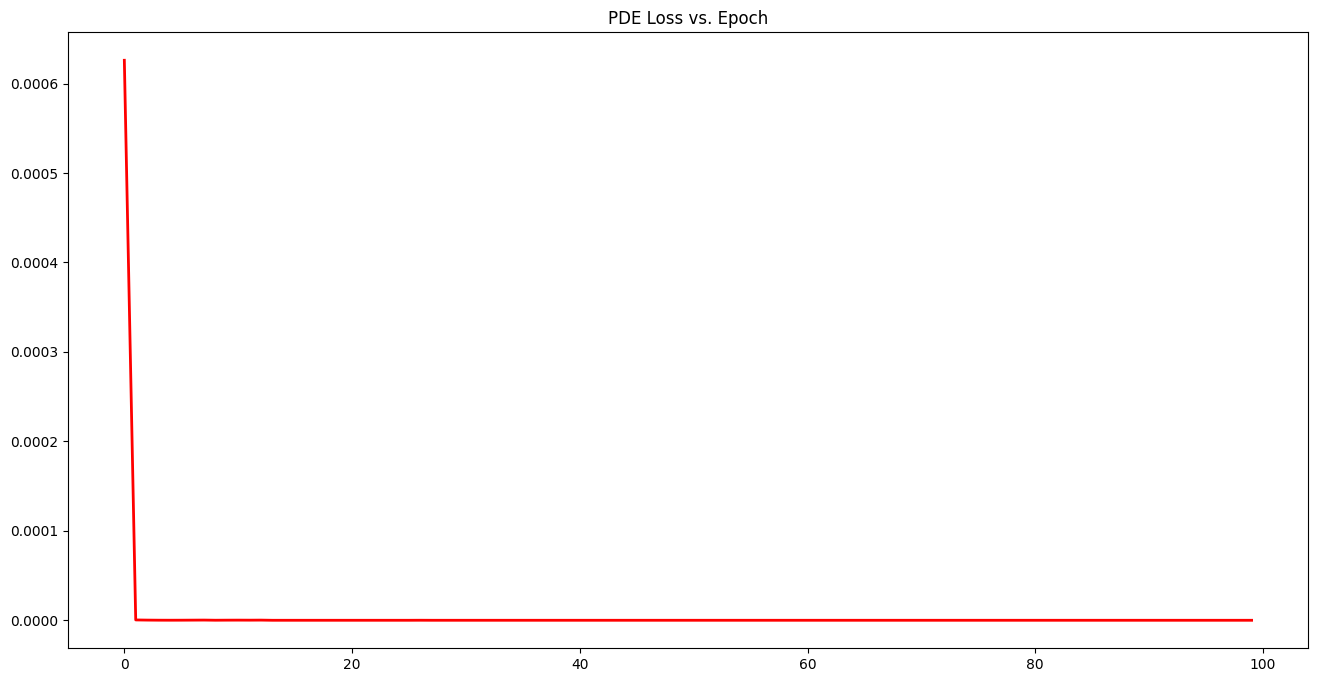

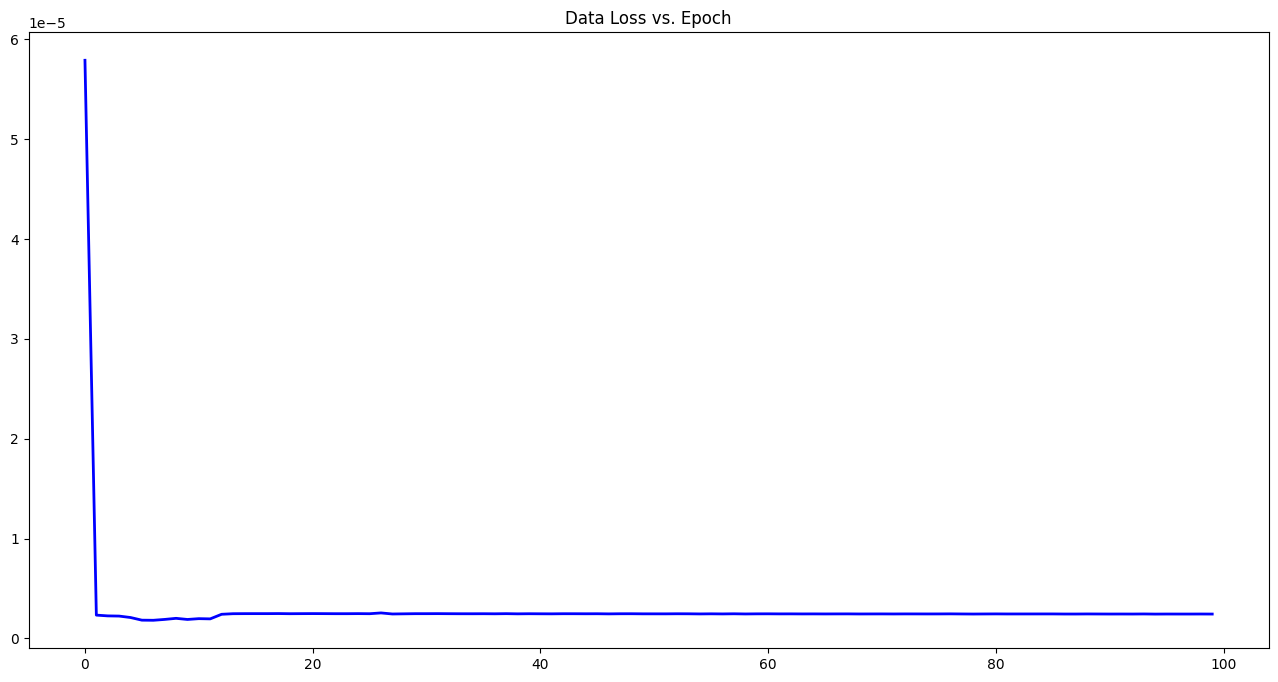

In [6]:
# visualize losses
plt.figure(1, figsize=(16, 8));
plt.plot(info["pde_loss"], lw=2, color="red");
plt.title("PDE Loss vs. Epoch");

plt.figure(2, figsize=(16, 8));
plt.plot(info["data_loss"], lw=2, color="blue");
plt.title("Data Loss vs. Epoch");

In [7]:
query = cartesian_data(pinn.tgrid, pinn.xgrid)

D_pred = pinn.D_nn(query).reshape(pinn.nx, pinn.nt).T.detach().numpy()
G_pred = pinn.G_nn(query).reshape(pinn.nx, pinn.nt).T.detach().numpy()
p_pred = pinn(query).reshape(pinn.nx, pinn.nt).T.detach().numpy()
p_exact = np.log(pinn.raw_data["pmc"])
p_exact = np.clip(p_exact, a_min=-100, a_max=float("inf"))

# grids
tgrid = pinn.tgrid.detach().numpy()
xgrid = pinn.xgrid.detach().numpy()

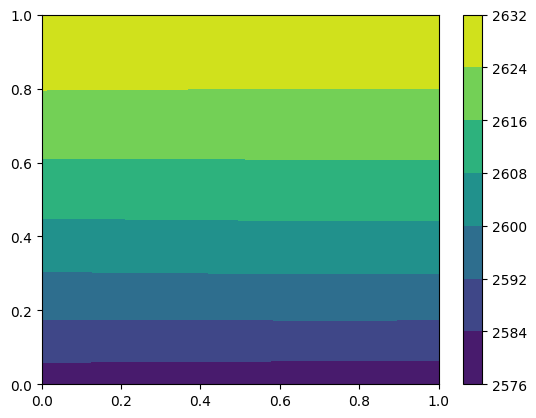

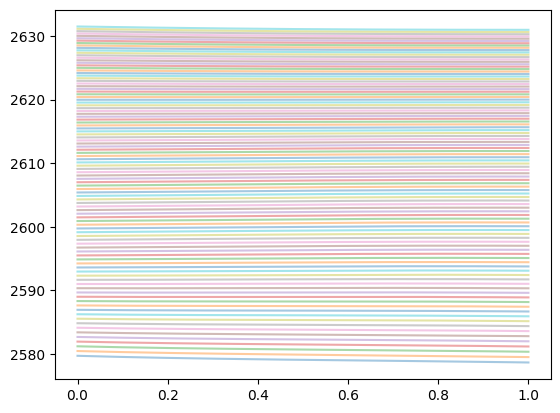

In [8]:
plt.figure(1);
plt.contourf(xgrid, tgrid, G_pred);
plt.colorbar()
plt.figure(2);
plt.plot(xgrid, G_pred[0:-1:10, :].T, alpha=0.4, lw=1.5);

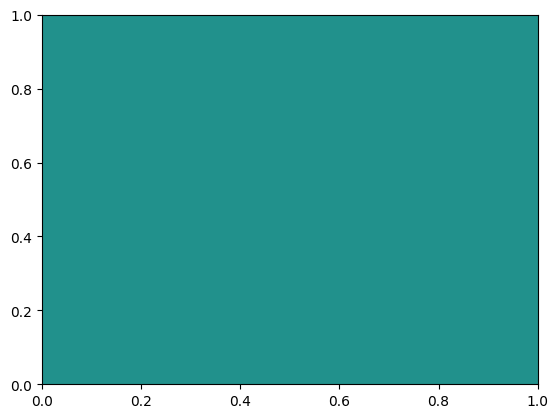

In [9]:
plt.contourf(pinn.xgrid.detach().numpy(), pinn.tgrid.detach().numpy(), p_pred)

In [ ]:
plt.figure(1);
idx = 29
plt.plot(xgrid, np.exp(p_pred[idx, :]), label="predict", color='blue')
plt.plot(xgrid, np.exp(p_exact[idx, :]), label="exact", color="red");
plt.legend();

plt.figure(2);
plt.plot(xgrid, p_pred[idx, :], label="predict", color="blue")
plt.plot(xgrid, p_exact[idx, :], label="exact", color="red");
plt.legend();


In [ ]:
plt.contourf(pinn.xgrid.detach().numpy(), pinn.tgrid.detach().numpy(), p_exact)

In [ ]:
xgrid = pinn.xgrid.detach().numpy()
dx = xgrid[1]-xgrid[0]
plt.figure(1);
fig, ax = plt.subplots(2, 2);
ax[0, 0].plot(xgrid, p_exact[0, :], label="KDE", lw=1.0, color="red");
ax[0, 0].plot(xgrid, p_pred[0, :], label="PINN", lw=1.0, color="blue");
ax[0, 0].set_title(r"$t = 0$");

ax[0, 1].plot(xgrid, p_exact[125, :], label="KDE", lw=1.0, color="red");
ax[0, 1].plot(xgrid, p_pred[125, :], label="PINN", lw=1.0, color="blue");
ax[0, 1].set_title(r"$t = 2.5$");

ax[1, 0].plot(xgrid, p_exact[250, :], label="KDE", lw=1.0, color="red");
ax[1, 0].plot(xgrid, p_pred[250, :], label="PINN", lw=1.0, color="blue");
ax[1, 0].set_title(r"$t = 5.0$");

ax[1, 1].plot(xgrid, p_exact[-1, :], label="KDE", lw=1.0, color="red");
ax[1, 1].plot(xgrid, p_pred[-1, :], label="PINN", lw=1.0, color="blue");
ax[1, 1].set_title(r"$t = 10.0$");

fig.set_figwidth(8);
fig.tight_layout(pad=0.5);

In [ ]:
plt.figure(2);
# relative error in L^2 from KDE benchmark
l2_rel_err = np.sum(((np.exp(p_pred)-np.exp(p_exact))**2)*dx, 1) / np.sum((np.exp(p_exact)**2)*dx, 1)
tgrid = pinn.tgrid.detach().numpy()
plt.plot(tgrid, l2_rel_err, color="red", lw=1.5);
plt.grid(True);
plt.title(r"Relative error in $L^2$");
plt.xlabel(r"$t$"); 
plt.ylabel(r"$L^2(\mathbb{R})$ error");